In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('energy.csv')

In [9]:
df.head()

,country,crude_oil_production,crude_oil_consumption,gas_production,gas_consumption,coal_production,coal_consumption,renew_share,energy_intensity,co2_intensity
0,Belgium,0,36,0,18,0,4,18.65,0.105,0.178
1,Czech Rep.,0,8,0,9,45,45,12.45,0.115,0.278
2,France,1,60,0,45,0,15,17.56,0.086,0.115
3,Germany,4,101,7,94,175,222,33.98,0.077,0.192
4,Italy,6,73,6,75,0,15,35.74,0.066,0.141


In [10]:
def normalize(df,cols):
    result = df.copy()
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

cols = ['crude_oil_production','crude_oil_consumption','gas_production','gas_consumption','coal_production','coal_consumption','renew_share','energy_intensity','co2_intensity']
new = normalize(df,cols)

In [12]:
new.head()

,country,crude_oil_production,crude_oil_consumption,gas_production,gas_consumption,coal_production,coal_consumption,renew_share,energy_intensity,co2_intensity
0,Belgium,0.000000,0.040524,0.000000,0.022339,0.000000,0.001109,0.190559,0.269430,0.220370
1,Czech Rep.,0.000000,0.007151,0.000000,0.010512,0.013437,0.012476,0.127210,0.321244,0.405556
2,France,0.001724,0.069130,0.000000,0.057819,0.000000,0.004159,0.179422,0.170984,0.103704
3,Germany,0.006897,0.117998,0.009126,0.122208,0.052254,0.061547,0.347195,0.124352,0.246296
4,Italy,0.010345,0.084625,0.007823,0.097240,0.000000,0.004159,0.365178,0.067358,0.151852


In [13]:
vecs = []
features = cols
for index, row in new.iterrows():
    vec = []
    vec.append(row['crude_oil_production'])
    vec.append(row['crude_oil_consumption'])
    vec.append(row['gas_production'])
    vec.append(row['gas_consumption'])
    vec.append(row['coal_production'])
    vec.append(row['coal_consumption'])
    vec.append(row['renew_share'])
    vec.append(row['energy_intensity'])
    vec.append(row['co2_intensity'])
    vecs.append(vec)

In [14]:
cos_sim_list = []
sim_index_list = []

In [15]:
def dot(A,B): 
    return (sum(a*b for a,b in zip(A,B)))
def cosine_similarity(a,b):
    return dot(a,b) / ( (dot(a,a) **.5) * (dot(b,b) ** .5) )

In [9]:
def generate_same_state_index(index):
    lis = []
    initial = (index+1)%52-1
    if initial == -1:
        initial = 51
    for i in range(17):
        temp = initial + i*52
        lis.append(temp)
    return lis        

In [10]:
vec_index = 0
for vec1 in vecs:
    cos_sim_list = []
    for vec2 in vecs:
        cos_sim_list.append(cosine_similarity(vec1,vec2))
    cos_sim_list = np.array(cos_sim_list)
    choices = cos_sim_list.argsort()[-21:][::-1][1:21]
    same = generate_same_state_index(vec_index)
    record =[]
    for choice in choices:
        if choice not in same:
            record.append(choice)
        if len(record)==3:
            break
    sim_index_list.append(record)
    vec_index+=1

In [11]:
col_edgelist = ['SourceNmae','TargetName','SourceID','TargetID','CosSim']
edgelist = pd.DataFrame(columns = col_edgelist)

In [12]:
source_index = 0
for indexes in sim_index_list:
    for target_index in indexes:
        
        source_name = str(new.loc[source_index]['year'])+'_'+new.loc[source_index]['state']
        target_name = str(new.loc[target_index]['year'])+'_'+new.loc[target_index]['state']
        cos_sim = cosine_similarity(vecs[source_index],vecs[target_index])
        
        record = [source_name,target_name,source_index,target_index,cos_sim]

        edgelist.loc[len(edgelist)] = record
    #print(source_index)
    source_index+=1

In [13]:
edgelist.head()

,SourceNmae,TargetName,SourceID,TargetID,CosSim
0,1999_Alabama,2003_Ohio,0,243,0.999351
1,1999_Alabama,2000_South Carolina,0,92,0.999348
2,1999_Alabama,2003_Idaho,0,220,0.997922
3,1999_Alaska,2002_Minnesota,1,179,0.988412
4,1999_Alaska,2001_New Hampshire,1,133,0.983352


In [14]:
df2 = pd.read_csv('cancer_cos_sim.csv')

In [15]:
df2.head()

,YEAR,POPULATION,COUNT,AGE_ADJUSTED_RATE,AREA
0,1999,4430141,9506,210.8,Alabama
1,1999,624779,633,193.8,Alaska
2,1999,5023823,9006,179.8,Arizona
3,1999,2651860,6137,213.9,Arkansas
4,1999,33499204,53064,185.1,California


In [16]:
col_nodelist = ['ID','NodeName','Rate','Vectors']
nodelist = pd.DataFrame(columns = col_nodelist)

In [17]:
len(df2)

867

In [18]:
df2.isnull().sum()

YEAR                 0
POPULATION           0
COUNT                0
AGE_ADJUSTED_RATE    0
AREA                 0
dtype: int64

In [19]:
new.isnull().sum()

year                       0
state                      0
Diabetes_Value             0
Income_Inequity            0
Median_Household_Income    0
Obesity                    0
Smoking                    0
dtype: int64

In [20]:
COLS=['YEAR','AREA','AGE_ADJUSTED_RATE']
df3 = pd.merge(new, df2[COLS], how='left', left_on=['year','state'], right_on=['YEAR','AREA'])

In [21]:
df3 = df3.drop(columns=['YEAR', 'AREA'])

In [22]:
df3.head()

,year,state,Diabetes_Value,Income_Inequity,Median_Household_Income,Obesity,Smoking,AGE_ADJUSTED_RATE
0,1999,Alabama,0.371681,0.304348,0.376656,0.381356,0.659574,210.8
1,1999,Alaska,0.017699,0.260870,0.854237,0.385593,0.723404,193.8
2,1999,Arizona,0.000000,0.429348,0.403934,0.033898,0.540426,179.8
3,1999,Arkansas,0.345133,0.336957,0.091925,0.317797,0.714894,213.9
4,1999,California,0.238938,0.407609,0.531187,0.211864,0.429787,185.1


In [23]:
df3.isnull().sum()

year                        0
state                       0
Diabetes_Value              0
Income_Inequity             0
Median_Household_Income     0
Obesity                     0
Smoking                     0
AGE_ADJUSTED_RATE          17
dtype: int64

In [24]:
df3['AGE_ADJUSTED_RATE'] = df3['AGE_ADJUSTED_RATE'].fillna(df3['AGE_ADJUSTED_RATE'].mean())
df3.head()

,year,state,Diabetes_Value,Income_Inequity,Median_Household_Income,Obesity,Smoking,AGE_ADJUSTED_RATE
0,1999,Alabama,0.371681,0.304348,0.376656,0.381356,0.659574,210.8
1,1999,Alaska,0.017699,0.260870,0.854237,0.385593,0.723404,193.8
2,1999,Arizona,0.000000,0.429348,0.403934,0.033898,0.540426,179.8
3,1999,Arkansas,0.345133,0.336957,0.091925,0.317797,0.714894,213.9
4,1999,California,0.238938,0.407609,0.531187,0.211864,0.429787,185.1


In [25]:
df3 = normalize(df3,['AGE_ADJUSTED_RATE'])
df3.head()

,year,state,Diabetes_Value,Income_Inequity,Median_Household_Income,Obesity,Smoking,AGE_ADJUSTED_RATE
0,1999,Alabama,0.371681,0.304348,0.376656,0.381356,0.659574,0.736707
1,1999,Alaska,0.017699,0.260870,0.854237,0.385593,0.723404,0.590909
2,1999,Arizona,0.000000,0.429348,0.403934,0.033898,0.540426,0.470840
3,1999,Arkansas,0.345133,0.336957,0.091925,0.317797,0.714894,0.763293
4,1999,California,0.238938,0.407609,0.531187,0.211864,0.429787,0.516295


In [26]:
node_index = 0
for index, row in df3.iterrows():
    
        node_name = str(df3.loc[node_index]['year'])+'_'+df3.loc[node_index]['state']
        rate = df3.loc[node_index]['AGE_ADJUSTED_RATE']
        vec = vecs[node_index]
        
        record = [node_index, node_name, rate, vec]

        nodelist.loc[len(nodelist)] = record
        #print(source_index)
        node_index+=1

In [27]:
nodelist.head()

,ID,NodeName,Rate,Vectors
0,0,1999_Alabama,0.736707,"[0.3716814159292035, 0.3043478260869566, 0.376..."
1,1,1999_Alaska,0.590909,"[0.0176991150442478, 0.2608695652173914, 0.854..."
2,2,1999_Arizona,0.470840,"[0.0, 0.42934782608695665, 0.40393403075781126..."
3,3,1999_Arkansas,0.763293,"[0.3451327433628319, 0.33695652173913054, 0.09..."
4,4,1999_California,0.516295,"[0.23893805309734514, 0.4076086956521737, 0.53..."


In [39]:
nodelist.to_csv('nodelist.csv',sep=',',header=True)

In [40]:
edgelist.to_csv('edgelist.csv',sep=',',header=True)

In [28]:
df3.head()

,year,state,Diabetes_Value,Income_Inequity,Median_Household_Income,Obesity,Smoking,AGE_ADJUSTED_RATE
0,1999,Alabama,0.371681,0.304348,0.376656,0.381356,0.659574,0.736707
1,1999,Alaska,0.017699,0.260870,0.854237,0.385593,0.723404,0.590909
2,1999,Arizona,0.000000,0.429348,0.403934,0.033898,0.540426,0.470840
3,1999,Arkansas,0.345133,0.336957,0.091925,0.317797,0.714894,0.763293
4,1999,California,0.238938,0.407609,0.531187,0.211864,0.429787,0.516295


In [29]:
df4 = df3.drop(columns=['year'])

In [30]:
df4.head()

,state,Diabetes_Value,Income_Inequity,Median_Household_Income,Obesity,Smoking,AGE_ADJUSTED_RATE
0,Alabama,0.371681,0.304348,0.376656,0.381356,0.659574,0.736707
1,Alaska,0.017699,0.260870,0.854237,0.385593,0.723404,0.590909
2,Arizona,0.000000,0.429348,0.403934,0.033898,0.540426,0.470840
3,Arkansas,0.345133,0.336957,0.091925,0.317797,0.714894,0.763293
4,California,0.238938,0.407609,0.531187,0.211864,0.429787,0.516295


In [31]:
state_group = df4.groupby('state')

In [32]:
Diabetes_Value = pd.DataFrame(state_group['Diabetes_Value'].mean().reset_index(name='Diabetes_Value'))
Income_Inequity = pd.DataFrame(state_group['Income_Inequity'].mean().reset_index(name='Income_Inequity'))
Median_Household_Income = pd.DataFrame(state_group['Median_Household_Income'].mean().reset_index(name='Median_Household_Income'))
Obesity = pd.DataFrame(state_group['Obesity'].mean().reset_index(name='Obesity'))
Smoking = pd.DataFrame(state_group['Smoking'].mean().reset_index(name='Smoking'))
AGE_ADJUSTED_RATE = pd.DataFrame(state_group['AGE_ADJUSTED_RATE'].mean().reset_index(name='AGE_ADJUSTED_RATE'))

In [33]:
df5 = pd.merge(Diabetes_Value, Income_Inequity, how='left', left_on=['state'], right_on=['state'])
df5 = pd.merge(df5, Median_Household_Income, how='left', left_on=['state'], right_on=['state'])
df5 = pd.merge(df5, Obesity, how='left', left_on=['state'], right_on=['state'])
df5 = pd.merge(df5, Smoking, how='left', left_on=['state'], right_on=['state'])
df5 = pd.merge(df5, AGE_ADJUSTED_RATE, how='left', left_on=['state'], right_on=['state'])

In [34]:
vecs2 = []
features = ['Diabetes_Value','Income_Inequity','Median_Household_Income','Obesity','Smoking']

for index, row in df5.iterrows():
    vec = []
    vec.append(round(row['Diabetes_Value'],2))
    vec.append(round(row['Income_Inequity'],2))
    vec.append(round(row['Median_Household_Income'],2))
    vec.append(round(row['Obesity'],2))
    vec.append(round(row['Smoking'],2))
    vecs2.append(vec)

In [35]:
vecs2[1]

[0.22, 0.17, 0.74, 0.54, 0.63]

In [17]:
cos_sim_list = []
sim_index_list2 = []
vecs2 = vecs

vec_index = 0
for vec1 in vecs2:
    cos_sim_list = []
    for vec2 in vecs2:
        cos_sim_list.append(cosine_similarity(vec1,vec2))
    cos_sim_list = np.array(cos_sim_list)
    choices = list(cos_sim_list.argsort()[-4:][::-1][1:4])
    sim_index_list2.append(choices)
    vec_index+=1

In [18]:
len(sim_index_list2)

44

In [19]:
sim_index_list2[:3]

[[33, 20, 2], [17, 32, 14], [0, 20, 3]]

In [20]:
col_edgelist = ['SourceNmae','TargetName','SourceID','TargetID','CosSim']
edgelist2 = pd.DataFrame(columns = col_edgelist)

source_index = 0
for indexes in sim_index_list2:
    for target_index in indexes:
        
        source_name = df.loc[source_index]['country']
        target_name = df.loc[target_index]['country']
        cos_sim = cosine_similarity(vecs[source_index],vecs[target_index])
        
        record = [source_name,target_name,source_index,target_index,cos_sim]

        edgelist2.loc[len(edgelist2)] = record
    #print(source_index)
    source_index+=1

In [21]:
edgelist2.head()

,SourceNmae,TargetName,SourceID,TargetID,CosSim
0,Belgium,Thailand,0,33,0.960693
1,Belgium,Argentina,0,20,0.954054
2,Belgium,France,0,2,0.946845
3,Czech Rep.,Uzbekistan,1,17,0.987454
4,Czech Rep.,Taiwan,1,32,0.978449


In [22]:
col_nodelist = ['ID','NodeName','Rate','Vectors']
nodelist2 = pd.DataFrame(columns = col_nodelist)

In [23]:
df.head()

,country,crude_oil_production,crude_oil_consumption,gas_production,gas_consumption,coal_production,coal_consumption,renew_share,energy_intensity,co2_intensity
0,Belgium,0,36,0,18,0,4,18.65,0.105,0.178
1,Czech Rep.,0,8,0,9,45,45,12.45,0.115,0.278
2,France,1,60,0,45,0,15,17.56,0.086,0.115
3,Germany,4,101,7,94,175,222,33.98,0.077,0.192
4,Italy,6,73,6,75,0,15,35.74,0.066,0.141


In [25]:
for index, row in df.iterrows():
    
    node_name = row['country']
    rate = round(row['energy_intensity'],2)
    
    vec=[]
    for element in vecs2[index]:
        element = round(element,2)
        vec.append(element)

    record = [index, node_name, rate, vec]

    nodelist2.loc[len(nodelist2)] = record
    
    

In [26]:
nodelist2.head()

,ID,NodeName,Rate,Vectors
0,0,Belgium,0.10,"[0.0, 0.04, 0.0, 0.02, 0.0, 0.0, 0.19, 0.27, 0..."
1,1,Czech Rep.,0.12,"[0.0, 0.01, 0.0, 0.01, 0.01, 0.01, 0.13, 0.32,..."
2,2,France,0.09,"[0.0, 0.07, 0.0, 0.06, 0.0, 0.0, 0.18, 0.17, 0.1]"
3,3,Germany,0.08,"[0.01, 0.12, 0.01, 0.12, 0.05, 0.06, 0.35, 0.1..."
4,4,Italy,0.07,"[0.01, 0.08, 0.01, 0.1, 0.0, 0.0, 0.37, 0.07, ..."


In [27]:
edgelist2.head()

,SourceNmae,TargetName,SourceID,TargetID,CosSim
0,Belgium,Thailand,0,33,0.960693
1,Belgium,Argentina,0,20,0.954054
2,Belgium,France,0,2,0.946845
3,Czech Rep.,Uzbekistan,1,17,0.987454
4,Czech Rep.,Taiwan,1,32,0.978449


In [28]:
edgelist2 = normalize(edgelist2,['CosSim'])
edgelist2.head()

,SourceNmae,TargetName,SourceID,TargetID,CosSim
0,Belgium,Thailand,0,33,0.891953
1,Belgium,Argentina,0,20,0.873065
2,Belgium,France,0,2,0.852555
3,Czech Rep.,Uzbekistan,1,17,0.968081
4,Czech Rep.,Taiwan,1,32,0.942465


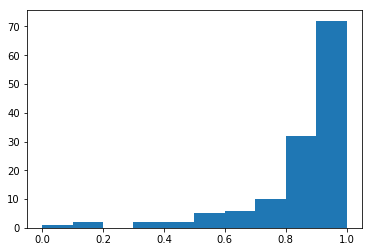

In [29]:
import matplotlib.pyplot as plt
plt.hist(edgelist2['CosSim'])
plt.show()

In [31]:
nodelist2.to_csv('nodelist_country.csv',sep=',',header=True)

In [30]:
edgelist2.to_csv('edgelist_country.csv',sep=',',header=True)